In [20]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt


def sir_model(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

def solve_sir(initial_conditions, t, beta, gamma):
    result = odeint(sir_model, initial_conditions, t, args=(beta, gamma))
    return result.T  # Transpose to get arrays of S, I, and R


In [21]:
df = pd.read_csv("full_grouped.csv")

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35156 entries, 0 to 35155
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            35156 non-null  object
 1   Country/Region  35156 non-null  object
 2   Confirmed       35156 non-null  int64 
 3   Deaths          35156 non-null  int64 
 4   Recovered       35156 non-null  int64 
 5   Active          35156 non-null  int64 
 6   New cases       35156 non-null  int64 
 7   New deaths      35156 non-null  int64 
 8   New recovered   35156 non-null  int64 
 9   WHO Region      35156 non-null  object
dtypes: int64(7), object(3)
memory usage: 2.7+ MB


In [23]:
df = df.loc[df['Country/Region'] == 'Spain']
df = df.groupby('Date').sum().reset_index()
df = df.loc[df['Confirmed'].ne(0).idxmax():].reset_index(drop=True)
#df.drop(df.index[:10], inplace=True)
df = df.reset_index(drop=True)

In [24]:
Infected_Conf = np.zeros(len(df.Date))
Infected_Conf_Recovered = np.zeros(len(df.Date))
Infected_Conf_Deaths_Recovered = np.zeros(len(df.Date))


In [25]:
print (df.Confirmed[100])

227436


In [26]:
cumsum_Conf = 0
cumsum_Conf_Recovered = 0
cumsum_Conf_Deaths_Recovered = 0    
for i in range(len(df.Date)):

    cumsum_Conf = df.Confirmed[i]
    cumsum_Conf_Recovered = df.Confirmed[i] - df.Recovered[i]
    cumsum_Conf_Deaths_Recovered = df.Confirmed[i] - df.Deaths[i] - df.Recovered[i]

    Infected_Conf[i] = cumsum_Conf
    Infected_Conf_Recovered[i] = cumsum_Conf_Recovered
    Infected_Conf_Deaths_Recovered[i] = cumsum_Conf_Deaths_Recovered


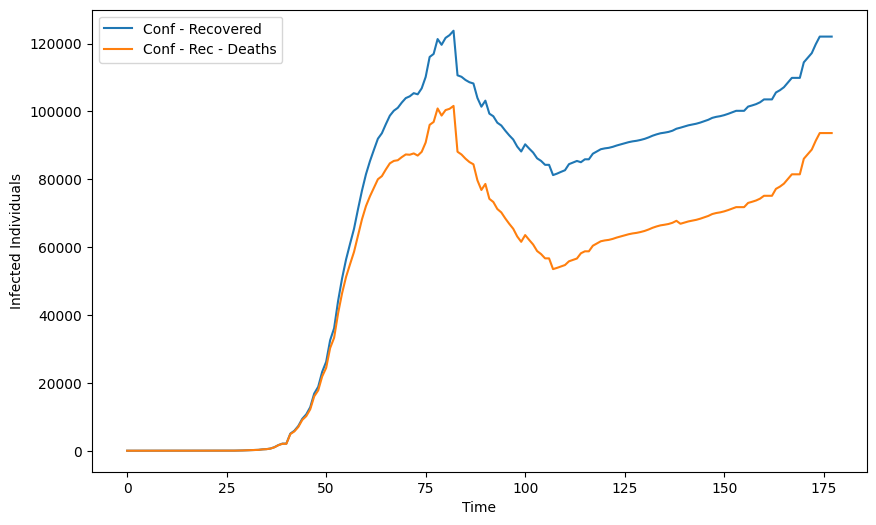

In [27]:
plt.figure(figsize=(10, 6))
t = np.arange(0,len(df.Date),1)
#plt.plot(t, df.Confirmed, '-', label='Conf only')
plt.plot(t, Infected_Conf_Recovered, '-', label='Conf - Recovered')
plt.plot(t, Infected_Conf_Deaths_Recovered, '-', label='Conf - Rec - Deaths')
plt.xlabel('Time')
plt.ylabel('Infected Individuals')
plt.legend()
plt.show()

In [28]:
# Example: real_data is the array of observed infected cases over time
#real_data = np.array([1, 3, 8, 20, 50, 80, 150, 200, 250, 300, 400, 500])
real_data = Infected_Conf_Deaths_Recovered
t = np.arange(len(real_data))  # Time points corresponding to the data


In [32]:
def objective(params, initial_conditions, t, real_data):
    beta, gamma = params
    _, I, _ = solve_sir(initial_conditions, t, beta, gamma)
    mse = np.mean((I - real_data) ** 2)
    return mse


In [87]:
#pip install deap


In [88]:
import random
from deap import base, creator, tools, algorithms

# Define the initial conditions
initial_conditions = [70000, 1, 0]  # Example: S0 = 999, I0 = 1, R0 = 0

# Define the bounds for beta and gamma
BOUNDS = [(0.0001, 1.0), (0.0001, 1.0)]

# Create the optimization problem
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, BOUNDS[0][0], BOUNDS[0][1])
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalSIR(individual):
    beta, gamma = individual
    return objective((beta, gamma), initial_conditions, t, real_data),

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutPolynomialBounded, low=[b[0] for b in BOUNDS], up=[b[1] for b in BOUNDS], eta=1.0, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evalSIR)

# Genetic Algorithm parameters
population = toolbox.population(n=100)
NGEN = 100
CXPB, MUTPB = 0.5, 0.2

# Run the genetic algorithm
algorithms.eaSimple(population, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN, verbose=True)

# Get the best solution
best_individual = tools.selBest(population, k=1)[0]
best_beta, best_gamma = best_individual
print(f"Best parameters: beta = {best_beta}, gamma = {best_gamma}")


c:\Users\Андрей\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\Андрей\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	100   
1  	57    
2  	57    
3  	51    
4  	52    
5  	54    
6  	69    
7  	60    
8  	60    
9  	51    
10 	58    
11 	62    
12 	65    
13 	54    
14 	72    
15 	57    
16 	58    
17 	69    
18 	58    
19 	68    
20 	49    
21 	56    
22 	66    
23 	57    
24 	48    
25 	64    
26 	62    
27 	68    
28 	61    
29 	57    
30 	51    
31 	58    
32 	58    
33 	72    
34 	63    
35 	63    
36 	58    
37 	45    
38 	60    
39 	59    
40 	63    
41 	59    
42 	63    
43 	68    
44 	65    
45 	70    
46 	53    
47 	57    
48 	65    
49 	64    
50 	54    
51 	54    
52 	63    
53 	60    
54 	72    
55 	68    
56 	61    
57 	54    
58 	63    
59 	61    
60 	52    
61 	58    
62 	57    
63 	62    
64 	65    
65 	61    
66 	65    
67 	64    
68 	58    
69 	66    
70 	67    
71 	63    
72 	47    
73 	62    
74 	58    
75 	58    
76 	57    
77 	55    
78 	62    
79 	61    
80 	66    
81 	51    
82 	56    
83 	58    
84 	56    
85 	62    
86 	61    
87 	71    
88 	63    
89 	59    

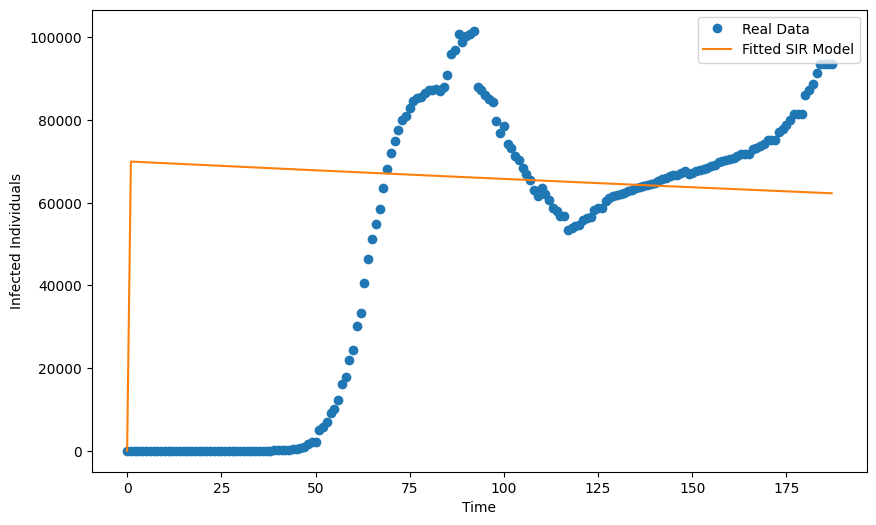

In [89]:

# Solve SIR with the best parameters
S, I, R = solve_sir(initial_conditions, t, best_beta, best_gamma)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, real_data, 'o', label='Real Data')
plt.plot(t, I, '-', label='Fitted SIR Model')
plt.xlabel('Time')
plt.ylabel('Infected Individuals')
plt.legend()
plt.show()


In [29]:
# Susceptible equation
def dS_dt(S, I, R_t, T_inf):
    return -(R_t / T_inf) * I * S

# Exposed equation
def dE_dt(S, E, I, R_t, T_inf, T_inc):
    return (R_t / T_inf) * I * S - (T_inc**-1) * E

# Infected equation
def dI_dt(I, E, T_inc, T_inf):
    return (T_inc**-1) * E - (T_inf**-1) * I

# Recovered/Remove/deceased equation
def dR_dt(I, T_inf):
    return (T_inf**-1) * I

def seir_model(y, t, R_t, T_inf, T_inc):
    S, E, I, R = y
    N = S + E + I + R
    dS_dt = -R_t * I * S / N / T_inf
    dE_dt = R_t * I * S / N / T_inf - E / T_inc
    dI_dt = E / T_inc - I / T_inf
    dR_dt = I / T_inf
    return dS_dt, dE_dt, dI_dt, dR_dt

In [30]:

def solve_seir(initial_conditions, t,  R_t, T_inf, T_inc):
    result = odeint(seir_model, initial_conditions, t, args=(R_t, T_inf, T_inc))
    return result.T  # Transpose to get arrays of S, I, and R

In [31]:
def objective_seir(params, initial_conditions, t, real_data):
    R_t, T_inf, T_inc = params
    _, I, _,_ = solve_seir(initial_conditions, t, R_t, T_inf, T_inc)
    mse = np.mean((I - real_data) ** 2)
    return mse

In [35]:
import random
from deap import base, creator, tools, algorithms

# Define the initial conditions
initial_conditions = [200000, 1, 0,0]  # Example: S0 = 999, I0 = 1, R0 = 0

# Define the bounds for beta and gamma
BOUNDS = [(0.0001, 100.0), (0.0001, 100.0),(0.0001, 100.0)]

# Create the optimization problem
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, BOUNDS[0][0], BOUNDS[0][1])
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=3)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalSEIR(individual):
    R_t, T_inf, T_inc = individual
    return objective_seir((R_t, T_inf, T_inc), initial_conditions, t, real_data),

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutPolynomialBounded, low=[b[0] for b in BOUNDS], up=[b[1] for b in BOUNDS], eta=1.0, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evalSEIR)

# Genetic Algorithm parameters
population = toolbox.population(n=100)
NGEN = 1000
CXPB, MUTPB = 0.5, 0.2


# Run the genetic algorithm
algorithms.eaSimple(population, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN, verbose=True)

# Get the best solution
best_individual = tools.selBest(population, k=1)[0]
R_t_best, T_inf_best, T_inc_best = best_individual
#print(f"Best parameters: beta = {best_beta}, gamma = {best_gamma}")


gen	nevals
0  	100   
1  	66    
2  	66    


C:\Users\Андрей\AppData\Local\Temp\ipykernel_24844\3032884688.py:2: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  result = odeint(seir_model, initial_conditions, t, args=(R_t, T_inf, T_inc))
C:\Users\Андрей\AppData\Local\Temp\ipykernel_24844\3032884688.py:2: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  result = odeint(seir_model, initial_conditions, t, args=(R_t, T_inf, T_inc))
C:\Users\Андрей\AppData\Local\Temp\ipykernel_24844\2395405673.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  dS_dt = -R_t * I * S / N / T_inf
C:\Users\Андрей\AppData\Local\Temp\ipykernel_24844\2395405673.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  dE_dt = R_t * I * S / N / T_inf - E / T_inc
C:\Users\Андрей\AppData\Local\Temp\ipykernel_24844\3032884688.py:2: ODEintWarning: Excess accuracy requested (toleran

3  	62    
4  	50    
5  	62    
6  	46    
7  	66    
8  	66    
9  	61    
10 	47    
11 	67    
12 	61    
13 	55    
14 	65    
15 	60    
16 	60    
17 	59    
18 	63    
19 	54    
20 	62    
21 	58    
22 	65    
23 	64    
24 	63    
25 	57    
26 	69    
27 	62    
28 	59    
29 	67    
30 	62    
31 	51    
32 	52    
33 	55    
34 	53    
35 	54    
36 	57    
37 	59    
38 	58    
39 	58    
40 	51    
41 	55    
42 	49    
43 	67    
44 	64    
45 	54    
46 	60    
47 	59    
48 	56    
49 	63    
50 	56    
51 	53    
52 	63    
53 	69    
54 	60    
55 	61    
56 	62    
57 	54    
58 	65    
59 	57    
60 	61    
61 	52    
62 	55    
63 	57    
64 	44    
65 	52    
66 	60    
67 	64    
68 	50    
69 	63    
70 	74    
71 	60    
72 	57    
73 	60    
74 	52    
75 	64    
76 	62    
77 	37    
78 	59    
79 	65    
80 	60    
81 	65    
82 	62    
83 	65    
84 	52    
85 	53    
86 	60    
87 	63    
88 	55    
89 	58    
90 	63    
91 	69    
92 	55    
93 	61    

C:\Users\Андрей\AppData\Local\Temp\ipykernel_24844\2395405673.py:20: RuntimeWarning: invalid value encountered in scalar divide
  dS_dt = -R_t * I * S / N / T_inf
C:\Users\Андрей\AppData\Local\Temp\ipykernel_24844\2395405673.py:21: RuntimeWarning: invalid value encountered in scalar divide
  dE_dt = R_t * I * S / N / T_inf - E / T_inc


173	62    
174	65    
175	60    
176	60    
177	62    
178	52    
179	57    
180	61    
181	55    
182	50    
183	47    
184	59    
185	66    
186	61    
187	56    
188	69    
189	56    
190	54    
191	54    
192	55    
193	67    
194	58    
195	70    
196	64    
197	67    
198	60    
199	67    
200	55    
201	62    
202	62    
203	61    
204	61    
205	67    
206	68    
207	67    
208	62    
209	64    
210	65    
211	60    
212	56    
213	56    
214	58    
215	55    
216	57    
217	52    
218	64    
219	74    
220	52    
221	57    
222	47    
223	65    
224	70    
225	53    
226	53    
227	63    
228	52    
229	66    
230	71    
231	52    
232	60    
233	51    
234	68    
235	61    
236	52    
237	54    
238	65    
239	63    
240	62    
241	50    
242	49    
243	54    
244	57    
245	61    
246	60    
247	50    
248	50    
249	56    
250	58    
251	56    
252	51    
253	72    
254	58    
255	65    
256	60    
257	49    
258	53    
259	54    
260	67    
261	63    
262	52    
263	65    

In [36]:
print(R_t_best, T_inf_best, T_inc_best)

11.103163381449557 1.6865572939957131e-06 52.363945093903446


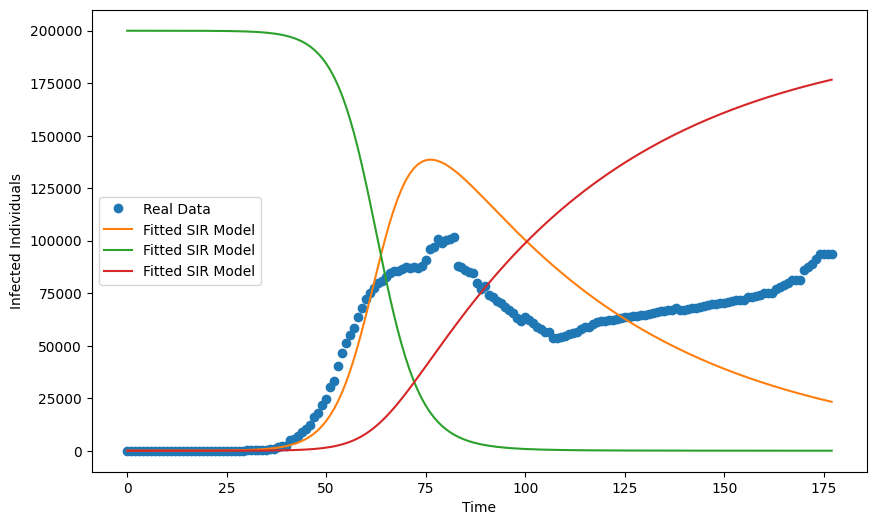

In [39]:

# Solve SIR with the best parameters
S, I, E, R = solve_seir(initial_conditions, t, R_t_best, T_inf_best, T_inc_best)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, real_data, 'o', label='Real Data')
plt.plot(t, I, '-', label='I')
plt.plot(t, S, '-', label='S')
plt.plot(t, R, '-', label='R')

plt.xlabel('Time')
plt.ylabel('Infected Individuals')
plt.legend()
plt.show()


In [40]:
!pip install seiqrdp-model


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("full_grouped.csv")

In [3]:
df = df.loc[df['Country/Region'] == 'Spain']
df = df.groupby('Date').sum().reset_index()
df = df.loc[df['Confirmed'].ne(0).idxmax():].reset_index(drop=True)
#df.drop(df.index[:10], inplace=True)
df = df.reset_index(drop=True)

In [4]:
Infected_Conf = np.zeros(len(df.Date))
Infected_Conf_Recovered = np.zeros(len(df.Date))
Infected_Conf_Deaths_Recovered = np.zeros(len(df.Date))


In [5]:
cumsum_Conf = 0
cumsum_Conf_Recovered = 0
cumsum_Conf_Deaths_Recovered = 0    
for i in range(len(df.Date)):

    cumsum_Conf = df.Confirmed[i]
    cumsum_Conf_Recovered = df.Confirmed[i] - df.Recovered[i]
    cumsum_Conf_Deaths_Recovered = df.Confirmed[i] - df.Deaths[i] - df.Recovered[i]

    Infected_Conf[i] = cumsum_Conf
    Infected_Conf_Recovered[i] = cumsum_Conf_Recovered
    Infected_Conf_Deaths_Recovered[i] = cumsum_Conf_Deaths_Recovered


In [6]:
# Example: real_data is the array of observed infected cases over time
#real_data = np.array([1, 3, 8, 20, 50, 80, 150, 200, 250, 300, 400, 500])
real_data = Infected_Conf_Deaths_Recovered
t = np.arange(len(real_data))  # Time points corresponding to the data


In [11]:
def seiqr_model(x, t, beta, gamma, alpha, delta, lambd, kappa):
    """
    SEIQR модель.
    x (элементы) = 0:I 1:E 2:Q 3:S 4:R 5:D 6:P 7:cQ
    """
    I, E, Q, S, R, D, P = x
    N = S + E + I + Q + R + D + P

    dSdt = - (beta * S * I) / N - alpha * S
    dEdt = (beta * S * I) / N - gamma * E
    dIdt = gamma * E - delta * I

    dQdt = delta * I - lambd * Q - kappa * Q
    dRdt = lambd * Q
    dDdt = kappa * Q
    dPdt = alpha * S

    return [dIdt, dEdt, dQdt, dSdt, dRdt, dDdt, dPdt]


In [12]:

def solve_seiqr(initial_conditions, t,  beta, gamma, alpha, delta, lambd, kappa):
    result = odeint(seiqr_model, initial_conditions, t, args=(beta, gamma, alpha, delta, lambd, kappa))
    return result.T  # Transpose to get arrays of S, I, and R

In [15]:
def objective_seiqr(params, initial_conditions, t, real_data):
    beta, gamma, alpha, delta, lambd, kappa = params
    I, _,_,_,_,_,_ = solve_seiqr(initial_conditions, t, beta, gamma, alpha, delta, lambd, kappa)
    mse = np.mean((I - real_data) ** 2)
    return mse

In [16]:
import random
from deap import base, creator, tools, algorithms

# Define the initial conditions
initial_conditions = [1, 1, 0,150000,1,1,1]  # Example: S0 = 999, I0 = 1, R0 = 0

# Define the bounds for beta and gamma
BOUNDS = [(0.000001, 100.0), (0.000001, 100.0),(0.000001, 100.0),(0.000001, 100.0),(0.000001, 100.0), (0.000001, 100.0)]

# Create the optimization problem
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, BOUNDS[0][0], BOUNDS[0][1])
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=6)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalSEIQR(individual):
    beta, gamma, alpha, delta, lambd, kappa = individual
    return objective_seiqr((beta, gamma, alpha, delta, lambd, kappa), initial_conditions, t, real_data),

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutPolynomialBounded, low=[b[0] for b in BOUNDS], up=[b[1] for b in BOUNDS], eta=1.0, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evalSEIQR)

# Genetic Algorithm parameters
population = toolbox.population(n=100)
NGEN = 500
CXPB, MUTPB = 0.5, 0.2


# Run the genetic algorithm
algorithms.eaSimple(population, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN, verbose=True)


#print(f"Best parameters: beta = {best_beta}, gamma = {best_gamma}")


gen	nevals
0  	100   


C:\Users\Андрей\AppData\Local\Temp\ipykernel_22728\3836687476.py:2: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  result = odeint(seiqr_model, initial_conditions, t, args=(beta, gamma, alpha, delta, lambd, kappa))
C:\Users\Андрей\AppData\Local\Temp\ipykernel_22728\3836687476.py:2: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  result = odeint(seiqr_model, initial_conditions, t, args=(beta, gamma, alpha, delta, lambd, kappa))


1  	56    
2  	65    


C:\Users\Андрей\AppData\Local\Temp\ipykernel_22728\3733045309.py:13: RuntimeWarning: overflow encountered in scalar multiply
  dQdt = delta * I - lambd * Q - kappa * Q
C:\Users\Андрей\AppData\Local\Temp\ipykernel_22728\3733045309.py:14: RuntimeWarning: overflow encountered in scalar multiply
  dRdt = lambd * Q
C:\Users\Андрей\AppData\Local\Temp\ipykernel_22728\3733045309.py:7: RuntimeWarning: invalid value encountered in scalar add
  N = S + E + I + Q + R + D + P
C:\Users\Андрей\AppData\Local\Temp\ipykernel_22728\3733045309.py:13: RuntimeWarning: invalid value encountered in scalar subtract
  dQdt = delta * I - lambd * Q - kappa * Q
C:\Users\Андрей\AppData\Local\Temp\ipykernel_22728\3836687476.py:2: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  result = odeint(seiqr_model, initial_conditions, t, args=(beta, gamma, alpha, delta, lambd, kappa))


3  	62    
4  	50    
5  	58    
6  	64    
7  	45    


C:\Users\Андрей\AppData\Local\Temp\ipykernel_22728\3733045309.py:15: RuntimeWarning: overflow encountered in scalar multiply
  dDdt = kappa * Q
C:\Users\Андрей\AppData\Local\Temp\ipykernel_22728\3836687476.py:2: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  result = odeint(seiqr_model, initial_conditions, t, args=(beta, gamma, alpha, delta, lambd, kappa))


8  	59    
9  	66    
10 	63    
11 	67    
12 	66    
13 	63    
14 	49    
15 	58    
16 	41    
17 	61    
18 	53    
19 	48    
20 	65    
21 	63    
22 	65    
23 	64    
24 	58    
25 	74    
26 	50    
27 	57    
28 	69    
29 	49    
30 	59    
31 	53    
32 	55    
33 	64    
34 	53    
35 	51    
36 	58    
37 	56    
38 	67    
39 	62    
40 	52    
41 	51    
42 	61    
43 	54    
44 	71    
45 	54    
46 	62    
47 	51    
48 	67    
49 	59    
50 	57    
51 	60    
52 	64    
53 	58    
54 	73    
55 	57    
56 	61    
57 	51    
58 	60    
59 	58    
60 	62    
61 	71    
62 	67    
63 	63    
64 	62    
65 	62    
66 	71    
67 	69    
68 	49    
69 	57    
70 	53    
71 	67    
72 	57    
73 	55    
74 	57    
75 	62    
76 	78    
77 	55    
78 	68    
79 	59    
80 	53    
81 	66    
82 	61    
83 	59    
84 	59    
85 	63    
86 	66    
87 	75    
88 	57    
89 	53    
90 	64    
91 	58    
92 	63    
93 	58    
94 	57    
95 	63    
96 	43    
97 	59    
98 	59    

([[143.82874410200077,
   50.28209449437844,
   4.809856421673004,
   1.0000000000000002e-06,
   72.2930165417761,
   94.93240785342283],
  [143.82874410200077,
   50.28209449437844,
   4.809856421673004,
   1.0000000000000002e-06,
   72.2930165417761,
   94.93240785342283],
  [143.82874410200077,
   50.28209449437844,
   4.809856421673004,
   1.0000000000000002e-06,
   72.2930165417761,
   94.93240785342283],
  [143.82874410200077,
   50.28209449437844,
   4.809856421673004,
   1.0000000000000002e-06,
   72.2930165417761,
   94.93240785342283],
  [143.82874410200077,
   50.28209449437844,
   4.809856421673004,
   1.0000000000000002e-06,
   72.2930165417761,
   94.93240785342283],
  [143.82874410200077,
   50.28209449437844,
   4.809856421673004,
   1.0000000000000002e-06,
   72.2930165417761,
   94.93240785342283],
  [143.82874410200077,
   50.28209449437844,
   4.809856421673004,
   1.0000000000000002e-06,
   72.2930165417761,
   94.93240785342283],
  [143.82874410200077,
   50.28209

In [17]:
# Get the best solution
best_individual = tools.selBest(population, k=1)[0]
beta, gamma, alpha, delta, lambd, kappa = best_individual

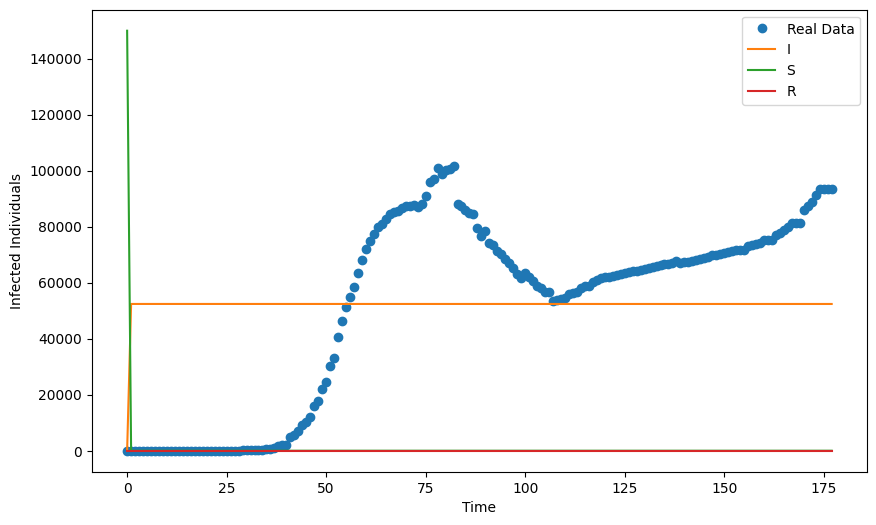

In [19]:

# Solve SIR with the best parameters
dIdt, dEdt, dQdt, dSdt, dRdt, dDdt, dPdt = solve_seiqr(initial_conditions, t, beta, gamma, alpha, delta, lambd, kappa)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, real_data, 'o', label='Real Data')
plt.plot(t, dIdt, '-', label='I')
plt.plot(t, dSdt, '-', label='S')
plt.plot(t, dRdt, '-', label='R')

plt.xlabel('Time')
plt.ylabel('Infected Individuals')
plt.legend()
plt.show()
